In [33]:
%matplotlib widget

from transformers import (
    AutoTokenizer,
    DataCollatorWithPadding,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    pipeline,
)
import os
import torch
import requests
from bs4 import BeautifulSoup
import re

from datasets import load_dataset, Dataset
import pandas as pd
import numpy as np
import evaluate
import glob

import matplotlib.pyplot as plt
import nltk

# Download the Punkt tokenizer models
nltk.download('punkt')


[nltk_data] Downloading package punkt to /home/andrej/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
MODEL_DIR = "/home/andrej/Code/story-vibe/data/models/checkpoint-08_07_2024"
device = torch.device('cpu')
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

# Parsing a book into a format for inference

In [73]:
# Load and segment the book
BOOK_PATH = "/home/andrej/Code/story-vibe/data/texts"

SPLIT = "sentence"  # "sentence"
with open(f'{BOOK_PATH}/alice_in_wonderland.txt', 'r') as file:
    book_text = file.read()

if SPLIT == "paragraph":
    segments = book_text.split('\n\n')
elif SPLIT == "sentence":
    segments = nltk.sent_tokenize(book_text)

def get_sentiment(text, argmax=False):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    inputs = {key: value.to(device) for key, value in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    scores = outputs.logits.softmax(dim=-1).cpu().numpy()[0]

    # return only the max sentiment
    if argmax is True:
        scores = torch.argmax(outputs.logits, dim=1).cpu().numpy()[0]
    return scores


sentiments = [get_sentiment(segment) for segment in segments]

# Convert to numpy array for easy plotting
sentiments = np.array(sentiments)


In [76]:
print(f"Sentiments: {sentiments}")
print(f"Shape of Sentiments: {sentiments.shape}")
print(f"Labels: {model.config.id2label}")

minimal_labels = {"positive": ["happiness"],
                  "neutral": ["neutral", "surprise"],
                  "negative": ["sadness", "fear", "anger", "disgust"]}

minimal_number_labels = {1: [model.config.label2id[label] for label in minimal_labels["positive"]],
                         0: [model.config.label2id[label] for label in minimal_labels["neutral"]],
                        -1: [model.config.label2id[label] for label in minimal_labels["negative"]]}

print(minimal_number_labels)
maximal_number_labels = [0] * len(model.config.id2label)
for key, val in minimal_number_labels.items():
    for v in val:
        maximal_number_labels[v] = key

print(f"maximal_number_labels: {maximal_number_labels}")

# remapped_sentiment = [maximal_number_labels[sent] for sent in sentiments]
# print(f"Remapped sentiment: {remapped_sentiment}")

Sentiments: [[3.1230666e-05 4.4737676e-06 4.3239488e-05 ... 2.5714377e-05
  4.3027121e-06 9.9988186e-01]
 [3.2926519e-06 2.0229001e-05 3.1675347e-05 ... 9.9911171e-01
  3.7717548e-06 7.1754190e-04]
 [5.7242789e-07 2.3513810e-06 6.9997009e-07 ... 9.9999201e-01
  4.1394804e-07 1.2892641e-06]
 ...
 [3.0346447e-07 1.3539124e-06 3.5630821e-06 ... 2.1447404e-06
  1.3955627e-06 9.9998963e-01]
 [4.5036506e-07 9.9952662e-01 1.2317135e-05 ... 7.5706212e-06
  9.5365931e-07 4.4807739e-04]
 [9.3223917e-07 1.5982536e-05 1.9894075e-07 ... 4.3792147e-06
  6.0990146e-06 9.9996471e-01]]
Shape of Sentiments: (1616, 7)
Labels: {0: 'sadness', 1: 'happiness', 2: 'fear', 3: 'anger', 4: 'surprise', 5: 'disgust', 6: 'neutral'}
{1: [1], 0: [6, 4], -1: [0, 2, 3, 5]}
maximal_number_labels: [-1, 1, -1, -1, 0, -1, 0]


# Plot 6 concurrent lines representing the sentiments

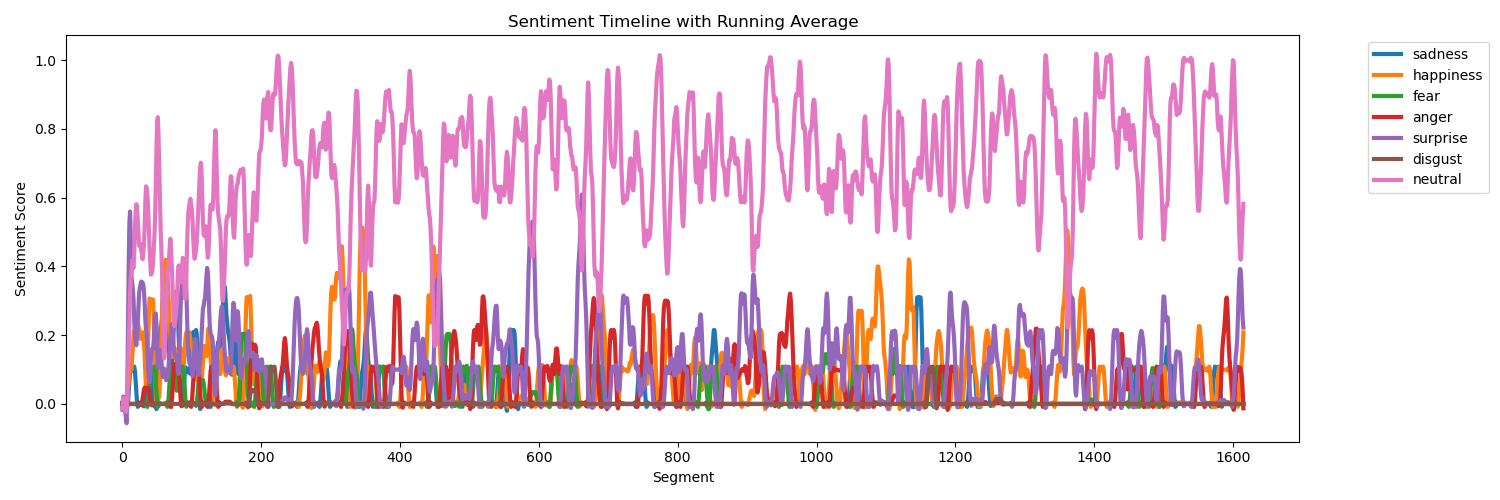

In [110]:
from scipy.signal import savgol_filter

def validate_data(data):
    """
    Ensure the data contains only finite numbers and handle NaNs.
    
    Parameters:
    data (numpy array): The input data array.
    
    Returns:
    numpy array: The validated data.
    """
    # Replace NaN and inf values with zeros
    data = np.nan_to_num(data)
    return data

# Apply Savitzky-Golay filter to smooth the running averages
def smooth_data(data, window_size, polyorder=2):
    """
    Smooth data using Savitzky-Golay filter.
    
    Parameters:
    data (numpy array): The input data array.
    window_size (int): The window size for the filter. It must be a positive odd integer.
    polyorder (int): The order of the polynomial used to fit the samples. Default is 2.
    
    Returns:
    numpy array: The smoothed data.

    """
    if window_size % 2 == 0:
        window_size += 1
    if window_size <= polyorder:
        window_size = polyorder + 1
        if window_size % 2 == 0:
            window_size += 1

    return savgol_filter(validate_data(data), window_size, polyorder)

def running_average(data, window_size):
    """
    Calculate the running average of a list with a specified window size.
    
    Parameters:
    data (list or numpy array): The input data list.
    window_size (int): The window size for calculating the running average.
    
    Returns:
    numpy array: The running averages with NaN padding for incomplete windows.
    """
    data = np.array(data)
    running_avg = np.full_like(data, np.nan, dtype=np.float64)
    if len(data) >= window_size:
        running_avg[window_size - 1:] = np.convolve(data, np.ones(window_size), 'valid') / window_size
    return running_avg


window_size = 10
running_avg_sentiments = np.array([running_average(sentiments[:, i], window_size) for i in range(sentiments.shape[1])]).T

smoothed_sentiments = np.array([smooth_data(running_avg_sentiments[:, i], 11, 4) for i in range(running_avg_sentiments.shape[1])]).T

# Plot sentiment timeline with running average
plt.figure(figsize=(15, 5))
for i, emotion in enumerate(['sadness', 'happiness', 'fear', 'anger', 'surprise', 'disgust', 'neutral']):
    plt.plot(smoothed_sentiments[:, i], label=emotion, lw=3)
plt.xlabel('Segment')
plt.ylabel('Sentiment Score')
plt.legend()
plt.title('Sentiment Timeline with Running Average')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()



# Plot the most positive and most negative parts

In [57]:
# most positive parts
positive_parts = [337, 1352]
negative_parts = [69, 668]

print(len(segments))

def get_surrounding_segments(index, segments, radius=5):
    min_id = max(0, index - radius)
    max_id = min(len(segments)-1, index + radius)
    return segments[min_id:max_id]

print(f"Showing the most positive indices: ")
for pos in positive_parts:
    print(get_surrounding_segments(pos, segments, radius=1))

print(f"Showing the most negative indices: ")
for neg in negative_parts:
    print(get_surrounding_segments(neg, segments, radius=1))

1616
Showing the most positive indices: 
["Only I don't think,' Alice went\non, `that they'd let Dinah stop in the house if it began ordering\npeople about like that!'", 'By this time she had found her way into a tidy little room with\na table in the window, and on it (as she had hoped) a fan and two\nor three pairs of tiny white kid gloves:  she took up the fan and\na pair of the gloves, and was just going to leave the room, when\nher eye fell upon a little bottle that stood near the looking-\nglass.']
['No accounting for tastes!', 'Sing her\n"Turtle Soup," will you, old fellow?\'']
Showing the most negative indices: 
["First, however, she waited for a few minutes to see if she was\ngoing to shrink any further:  she felt a little nervous about\nthis; `for it might end, you know,' said Alice to herself, `in my\ngoing out altogether, like a candle.", "I wonder what I should be\nlike then?'"]
["Alice caught the baby with some difficulty, as it was a queer-\nshaped little creature, and he